In [8]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from rebound.interruptible_pool import InterruptiblePool

In [15]:
def simulation(param):
    P_0, P2 = param
    ecc, mu1, mu2 = 0.05, 1e-6, 1e-6
    P1, lambda_0 = 1, 0
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1)
    sim.add(m=mu2, P=P2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    try:
        sim.integrate(1e5*2.*np.pi, exact_finish_time=0) # integrate for 1e4 orbitals, integrating to the nearest
        megno = sim.calculate_megno() 
        return megno
    except rebound.Collision:
        return 10.
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [16]:
Ngrid_x = 50
Ngrid_y = 50


r10 = np.linspace(0.5,0.75,Ngrid_x)
r20 = np.linspace(1.3,2,Ngrid_y)
parameters = [[1/x,y/x] for x in r10 for y in r20]

pool = InterruptiblePool()
results = pool.map(simulation,parameters)

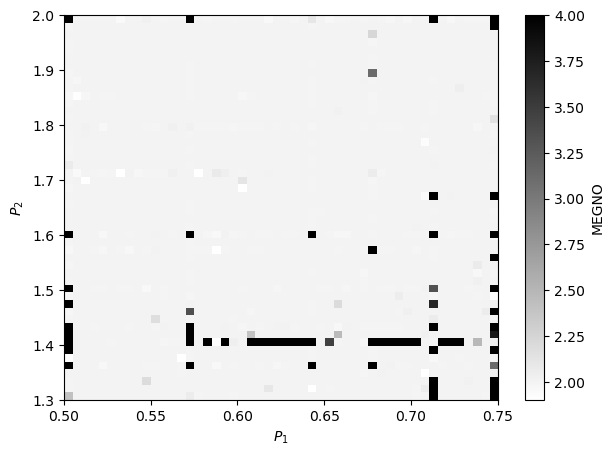

In [17]:
results2d = np.array(results).reshape(Ngrid_y,Ngrid_x)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(r10),max(r10),min(r20),max(r20)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$P_1$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$P_2$")
im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1.9, vmax=4, cmap="binary", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO")